# Code Setup
* importing required libaries needed for the project
* loading and transforming our datasets

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True )
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from PIL import Image
import torch
import pandas as pd
from google.colab import files
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
!pip install ipython-autotime
%load_ext autotime

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=d1622ba61b8a585954cd60db3ad4ed7de58a465694712ae971996949626e62d2
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
ROOT_DIR="./gdrive/My Drive/Colab Notebooks/COMP4900A3/Data/"
TRAIN_P=ROOT_DIR+"Train.pkl"
TRAIN_L=ROOT_DIR+"TrainLabels.csv"
TEST_P=ROOT_DIR+"Test.pkl"
Kaggle=ROOT_DIR + "kaggleSubmission.csv"
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
data = pickle.load( open( TRAIN_P, 'rb' ), encoding='bytes')
targets = np.genfromtxt(TRAIN_L, delimiter=',')

time: 19 s


In [3]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

time: 968 µs


In [4]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True
class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',')
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

# Data set used for kaggle submission
class kaggleDS(Dataset):
    def __init__(self, img_file, transform=None,):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.transform=transform
      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img

dataset = MyDataset(TRAIN_P, TRAIN_L,transform=img_transform, idx=None)
batch_size = 512 #feel free to change it
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


time: 1.06 s


# Creating functions to train and test our models
Train 2 and Test 2 are for the Validation

In [5]:

def train(model,epoch,optimizer,use_gpu=False):
  train_losses = []
  train_counter = []
  if use_gpu:
    model.cuda() # put our model on the gpu
  model.train()
  
  loss_f = torch.nn.CrossEntropyLoss() # Loss function  
  for epoch in range(1,epoch+1):
    for batch_idx,(data) in enumerate(dataloader):
      [data,label]=data
      if use_gpu:
            data, label = data.cuda(), label.cuda()
      model.zero_grad()  # sets gradients to 0 before loss calc. 
      output = model(data) # model makes predictions
      loss = loss_f(output, label)  # calc and grab the loss value
      
      loss.backward()  # apply this loss backwards thru the network's parameters
      optimizer.step()  # attempt to optimize weights to account for loss/gradients
    
      if batch_idx % 20 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(dataloader.dataset),
          100. * batch_idx / len(dataloader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))
        torch.save(model.state_dict(), '/model.pth')
        torch.save(optimizer.state_dict(), '/optimizer.pth')

  fig = plt.figure()
  plt.plot(train_counter, train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of training examples seen')
  plt.ylabel('negative log likelihood loss')
  fig.show()

time: 20.5 ms


In [6]:
def train2(model,epoch,optimizer,dataLoaderToUse, use_gpu=False):
  train_losses = []
  train_counter = []
  if use_gpu:
    model.cuda() # put our model on the gpu
  model.train()
  
  loss_f = torch.nn.CrossEntropyLoss() # Loss function  
  for epoch in range(1,epoch+1):
    for batch_idx,(data) in enumerate(dataLoaderToUse):
      [data,label]=data
      if use_gpu:
            data, label = data.cuda(), label.cuda()
      model.zero_grad()  # sets gradients to 0 before loss calc. 
      output = model(data) # model makes predictions
      loss = loss_f(output, label)  # calc and grab the loss value
      
      loss.backward()  # apply this loss backwards thru the network's parameters
      optimizer.step()  # attempt to optimize weights to account for loss/gradients
    
      if batch_idx % 20 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(dataLoaderToUse.dataset),
          100. * batch_idx / len(dataLoaderToUse), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(dataLoaderToUse.dataset)))
        torch.save(model.state_dict(), '/model.pth')
        torch.save(optimizer.state_dict(), '/optimizer.pth')

  fig = plt.figure()
  plt.plot(train_counter, train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of training examples seen')
  plt.ylabel('negative log likelihood loss')
  fig.show()

time: 20.7 ms


In [7]:
def test(model):
  correct = 0
  total = 0
  output=[]
  model.eval()
  model.cuda()
  classPredictions = [0,0,0,0,0,0,0,0,0,0]
  with torch.no_grad():
      for data in dataloader:
          [data,label]=data
          data=data.cuda()
          label=label.cuda()
          output = model(data)
        
          for idx, i in enumerate(output):
              
              if torch.argmax(i) == label[idx]:
                  correct += 1
              total += 1
              classPredictions[torch.argmax(i)] += 1

  print("Accuracy: ", round(correct/total, 3))
  print("Class Predictions: ")

  for i in range(len(classPredictions)):
    print(i, classPredictions[i])

time: 10.3 ms


In [8]:

def test2(model, dataLoaderToUse):
  correct = 0
  total = 0
  output=[]
  model.eval()
  model.cuda()
  classPredictions = [0,0,0,0,0,0,0,0,0,0]
  with torch.no_grad():
      for data in dataLoaderToUse:
          [data,label]=data
          data=data.cuda()
          label=label.cuda()
          output = model(data)
        
          for idx, i in enumerate(output):
              
              if torch.argmax(i) == label[idx]:
                  correct += 1
              total += 1
              classPredictions[torch.argmax(i)] += 1

  print("Accuracy: ", round(correct/total, 3))
  print("Class Predictions: ")

  for i in range(len(classPredictions)):
    print(i, classPredictions[i])

  return round(correct/total, 3)


time: 14.2 ms


In [9]:

# Checking GPU availability
use_gpu = torch.cuda.is_available()

time: 65.9 ms


# Basic Convolutional NN
* Larger number of out channels , learn more features of the picture, matter of preference
* size of conv layer is affect by in_channel , out_channel and how many channels
* kernal_size = N square filter , can be given as a tuple. Common dimensions include 1×1, 3×3, 5×5, and 7×7 which can be passed as (1, 1), (3, 3), (5, 5), or (7, 7) tuples.
* Don't change stride or padding , unless have good reasons to do so

In [12]:
IMG_DIM=(64,128)
class BasicCNN(nn.Module):
  def __init__(self):
    super(BasicCNN,self).__init__()
    self.conv1= nn.Conv2d(in_channels=1,out_channels=80,kernel_size=7,stride=1,padding=1)
    self.conv2= nn.Conv2d(80,40,5)
    self.conv3= nn.Conv2d(40,20,3)
    self.conv4= nn.Conv2d(20,10,3)
    self.pool1=nn.MaxPool2d(2)
    self.drop1=nn.Dropout(0.5)
    self.drop2=nn.Dropout(0.20)
    self.fc1 = nn.Linear(50, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, X):
    X = F.relu(self.pool1(self.conv1(X)))
    X = F.relu(self.pool1(self.conv2(X))) 
    X = F.relu(self.pool1(self.conv3(X))) 
    X = F.relu(self.pool1(self.conv4(X))) 
    X = X.flatten(1)
    X = F.relu(self.drop1(self.fc1(X)))
    X = self.drop2(self.fc2(X))
    return F.softmax(X)  


time: 13.2 ms


# LeNet

In [11]:
IMG_DIM=(64,128)
class LeNetCNN(nn.Module):
  def __init__(self):
    super(LeNetCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5) #out: 60 x 124 x 6
    #Max Pool out: 30 x 62 x 6
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5) #out: 26 x 58 x 16
    #Max Pool out: 13 x 29 x 16
    self.conv3 = nn.Conv2d(16, 120, kernel_size=5) #out: 9 x 25 x 120

    #self.dropout1 = nn.Dropout(0.7)
    self.dropout2 = nn.Dropout(0.7)

    self.fc1 = nn.Linear(27000, 120)
    self.fc2 = nn.Linear(120, 10) 

  def forward(self, x):

    x = F.relu(F.avg_pool2d(self.conv1(x), 2))
    #x = nn.BatchNorm2d(x)
    x = F.relu(F.avg_pool2d(self.conv2(x), 2))
    #x =nn.BatchNorm2d(x)
    x = F.relu(self.conv3(x), 2)

    
    # Imaginary Layer (11*25*120 = 4096)
    x = x.view(-1, 27000)

    #Feed forward layers
    x = self.dropout2(F.relu(self.fc1(x)))
    #x = F.relu(self.dropout2(self.fc2(x)))
    x = F.relu(self.fc2(x))
    #Output layer
    return F.log_softmax(x)


time: 21.2 ms


# VGG-16 Net



In [0]:
IMG_DIM=(64,128)
class VGGNet(nn.Module):
  #Define Layers
  def __init__(self):
    super(VGGNet,self).__init__()
    #If this does not work, change 1 -> 3 and convert our greyscale to have 3 channels
    self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

    self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    #Modified Feed Forward Layers
    self.fc1 = nn.Linear(4096, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, 10)


  def forward(self, x):
    #x: 64, 128, 1 (change to 3 if this doesnt work and modify input files)

    x = F.relu(self.conv1_1(x))
    x = F.relu(F.max_pool2d(self.conv1_2(x), 2))
    #Output: 32, 64, 64

    x = F.relu(self.conv2_1(x))
    x = F.relu(F.max_pool2d(self.conv2_2(x), 2))
    #Output: 16, 32, 128

    x = F.relu(self.conv3_1(x))
    x = F.relu(self.conv3_2(x))
    x = F.relu(F.max_pool2d(self.conv3_3(x), 2))
    #Output: 8, 16, 256

    x = F.relu(self.conv4_1(x))
    x = F.relu(self.conv4_2(x))
    x = F.relu(F.max_pool2d(self.conv4_3(x), 2))
    #Output: 4, 8, 512 

    x = F.relu(self.conv5_1(x))
    x = F.relu(self.conv5_2(x))
    x = F.relu(F.max_pool2d(self.conv5_3(x), 2))
    #Output: 2, 4, 512 

    # Imaginary Layer (2*4*512 = 4096)
    x = x.view(-1, 4096)


    #Feed forward layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    #Output layer
    return F.softmax(x)


time: 56.5 ms


In [15]:
# function to test for submission 
def testKaggle(model):
  fileName="kaggle submission.csv"
  submissionPD=pd.read_csv(Kaggle,header=0)
  output=[]
  kaggle_ds= kaggleDS(TEST_P,img_transform)
  kaggleDSLoader=DataLoader(kaggle_ds,10)
  for data in kaggleDSLoader:
    data=data.cuda()
    p_labels=model(data)
    output.append([torch.argmax(x) for x in p_labels])
  output=torch.flatten(torch.IntTensor(output),end_dim=1)
  output=torch.reshape(output,(1,10000))

  answer=list()

  for x in range(len(output[0])):
    answer.append(output[0][x].item())
  submissionPD.output=answer
  submissionPD.to_csv(fileName,index=False)
  files.download(fileName)




time: 9.44 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301898
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.303702
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.271596
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.226612
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.176420
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.106870
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.971338
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.743133
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.601984
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.463724
Train Epoch: 2 [40960/60000 (68%)]	Loss: 1.343700
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.508158
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.271572
Train Epoch: 3 [10240/60000 (17%)]	Loss: 1.293218
Train Epoch: 3 [20480/60000 (34%)]	Loss: 1.148589
Train Epoch: 3 [30720/60000 (51%)]	Loss: 1.205290
Train Epoch: 3 [40960/60000 (68%)]	Loss: 1.118446
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.159946
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.021432
Train Epoch: 4 [10240/60000 (17%)]	Loss: 1.153931
Train Epoch: 4 [2048

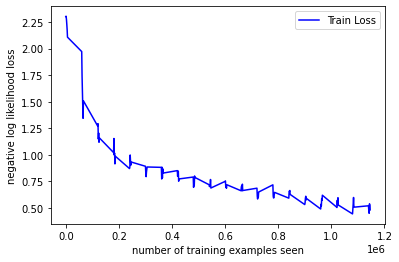

time: 20min 40s


In [0]:

model = LeNetCNN()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
train(model,20,optimizer,use_gpu)
test(model)

In [0]:
testKaggle(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


time: 7.28 s


In [28]:
#Split into train and validation
train_data, test_data = random_split(dataloader.dataset, (50000, 10000))

batch_size = 256

train_dataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataLoader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


valModel = LeNetCNN()
optimizer=torch.optim.Adam(valModel.parameters(),lr=0.001)
train2(valModel,20,optimizer,train_dataLoader,use_gpu)
testAccuracy = test2(valModel, test_dataLoader)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302084
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.307725
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.296744
Train Epoch: 1 [15360/50000 (31%)]	Loss: 2.266461
Train Epoch: 1 [20480/50000 (41%)]	Loss: 2.250244
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.151951
Train Epoch: 1 [30720/50000 (61%)]	Loss: 2.112325
Train Epoch: 1 [35840/50000 (71%)]	Loss: 1.938326
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.950877
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.813047
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.682885


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-baf526fd274c>", line 11, in <module>
    train2(valModel,20,optimizer,train_dataLoader,use_gpu)
  File "<ipython-input-6-4ccbf7d202c3>", line 29, in train2
    torch.save(optimizer.state_dict(), '/optimizer.pth')
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 327, in save
    with _open_file_like(f, 'wb') as opened_file:
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 212, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 193, in __init__
    super(_open_file, self).__init__(open(name, mode))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/u

KeyboardInterrupt: ignored

time: 10.7 s


In [0]:
testKaggle(valModel)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


time: 6.75 s
